# Image Cross-Correlation of Ball Viscometer

This program tracks a ball bearing moving in a sequence of high speed images.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 07/06/2022
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia

In [1]:
from pySciCam.pySciCam import ImageSequence # https://github.com/djorlando24/pySciCam
import numpy as np
import glob, sys, os
import matplotlib.pyplot as plt
from scipy import optimize
import tqdm
from joblib import Parallel, delayed
%matplotlib notebook

In [45]:
### Read images.
THETA=50
srcdir = "/Users/dduke/Desktop/Viscosity_mp4/vis_Inclination_%2i/" % THETA
SPATIAL_RES = None # pixel per micron
FRAME_RATE = 500. # frames/s
THETA *= np.pi/180. # angle

I=ImageSequence(srcdir, IO_threads=2)

Reading /Users/dduke/Desktop/Viscosity_mp4/vis_Inclination_50/
	Found 930 images with extension .tiff
	PythonMagick thinks the bit depth is <class 'numpy.uint16'>
	Increasing stored bit depth from <class 'numpy.uint16'> to <class 'numpy.uint32'>
	Reading files into memory...
20 tasks on 2 processors


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    9.3s
[Parallel(n_jobs=2)]: Done  21 out of  21 | elapsed:   13.0s finished


Read 499.5 MiB in 13.6 sec
	Data in memory:	 (930, 220, 1280)
	Intensity range:	 0 to 38920 	 uint32
	Array size:	999.0 MB


<IPython.core.display.Javascript object>


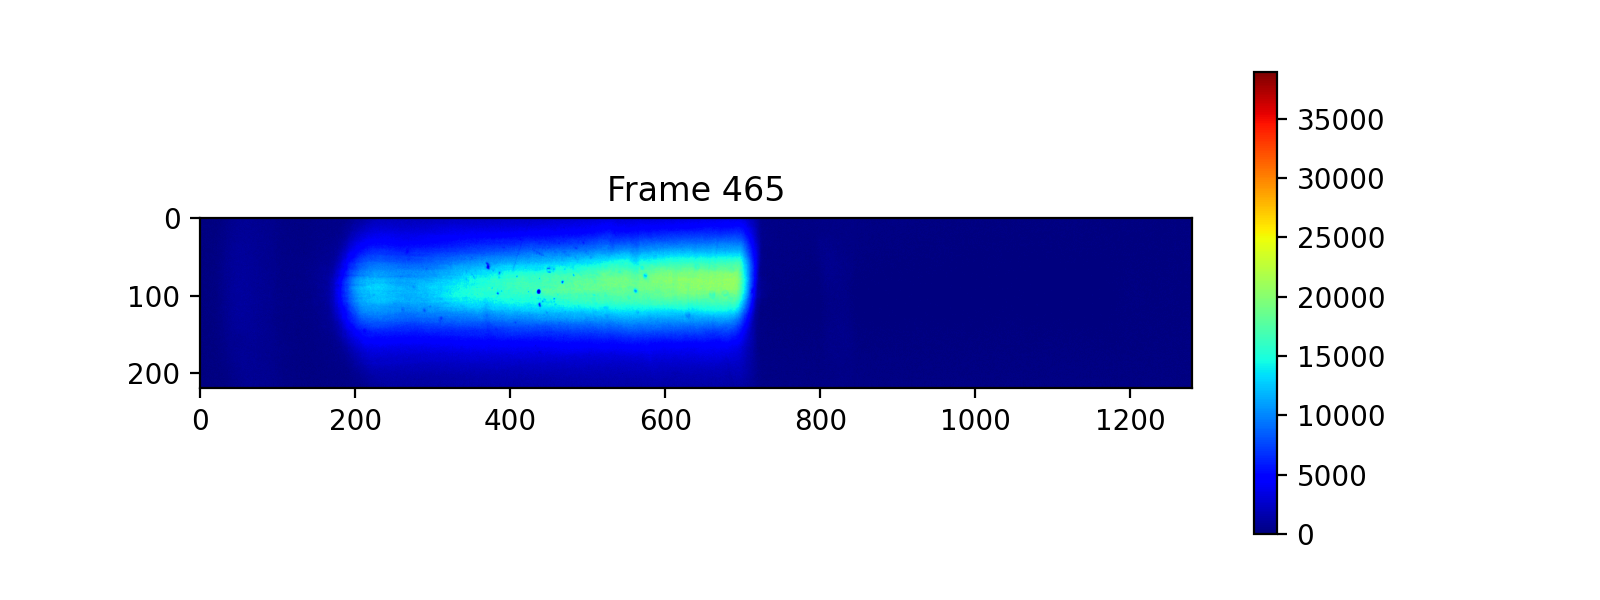

(930, 220, 1280)


In [46]:
# Sample raw image
fig=plt.figure(figsize=(8,3))
ax=fig.add_subplot(111)
plt.title("Frame %i" % (int(I.N/2)))
h=ax.imshow(I.arr[int(I.N/2),...],cmap=plt.cm.jet)
plt.colorbar(h)
plt.show()
print(I.arr.shape)

## Crop image to remove regions with poor contrast

In [47]:
# Crop images
#I.crop(0,220,240,1180) # 20º
#I.crop(0,220,240,1030)  # 30º
I.crop(0,220,200,700)  # 50º

## Remove image background
Division method

In [48]:
# No background removal?
#Ib=I.arr/np.nanmax(I.arr)

# Remove background, put into array Ib
Ib = np.zeros_like(I.arr,dtype=np.float32)
bkgnd = np.nanmean(I.arr[:5,...].astype(np.float32),axis=0) # First 5 images are reference background
bkgnd[bkgnd<=0] = np.nan
for n in range(I.N):
    Ib[n,...] = I.arr[n,...] / bkgnd  # Division

# Convert to extinction
Ib = 1.0 - Ib

<IPython.core.display.Javascript object>


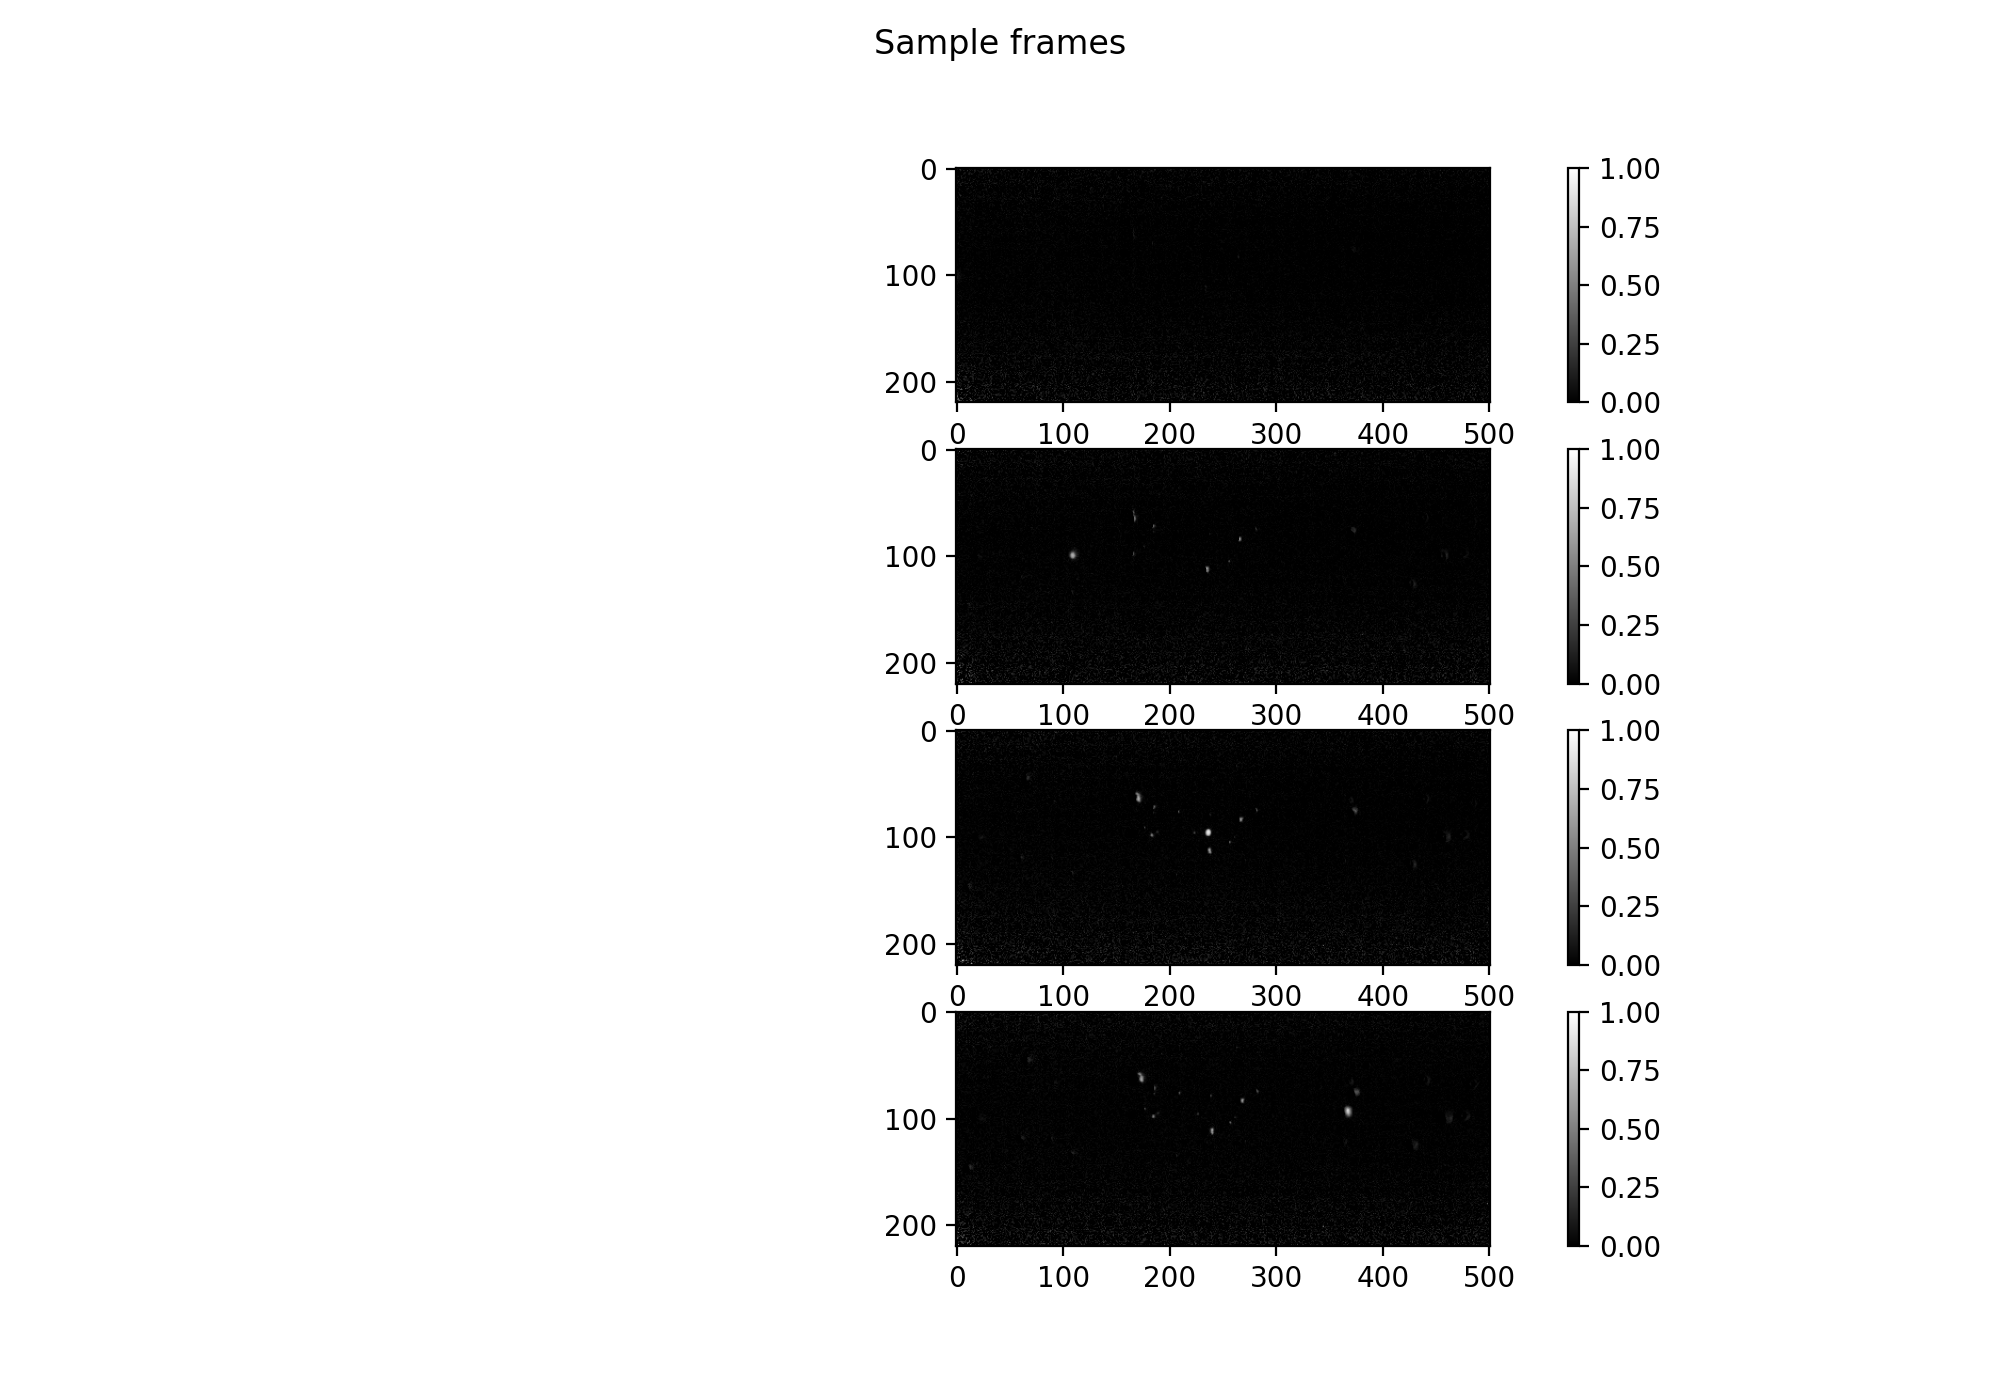

In [49]:
# Show some samples
fig=plt.figure(figsize=(10,7))
plt.suptitle("Sample frames\n"+os.path.basename(srcdir))
ax=fig.add_subplot(411)
h=ax.imshow(Ib[25,...],cmap=plt.cm.gray,vmin=0,vmax=1)
plt.colorbar(h)
ax=fig.add_subplot(412)
h=ax.imshow(Ib[int(I.N/4),...],cmap=plt.cm.gray,vmin=0,vmax=1)
plt.colorbar(h);
ax=fig.add_subplot(413)
h=ax.imshow(Ib[int(I.N/2),...],cmap=plt.cm.gray,vmin=0,vmax=1)
plt.colorbar(h);
ax=fig.add_subplot(414)
h=ax.imshow(Ib[3*int(I.N/4),...],cmap=plt.cm.gray,vmin=0,vmax=1)
plt.colorbar(h);

## Find the approximate position of the ball in each image
Look for local maximum in the extinction signal. This will get us within a few pixels.

In [50]:
INTENSITY_THRESHOLD=0.45 # 0.1
Y_MARGIN_PX = 50 # don't allow within this many pixels of the top/bottom edge
X_MIN_PX = 5 # reduce X range?
X_MAX_PX = -1 # reduce X range?

# Get location of the peak if it is above a threshold and not too close to the edge of the image.
xy_peak = []; maxvals=[]
for i in range(I.N):
    maxval=np.nanmax(Ib[i,Y_MARGIN_PX:-Y_MARGIN_PX,X_MIN_PX:X_MAX_PX])
    if maxval<INTENSITY_THRESHOLD: 
        xy_peak.append((np.nan,np.nan))
    else:
        xy=np.where(Ib[i,Y_MARGIN_PX:-Y_MARGIN_PX,X_MIN_PX:X_MAX_PX]==maxval)
        xy_peak.append((xy[1][0]+X_MIN_PX,xy[0][0]+Y_MARGIN_PX))
    maxvals.append(maxval)
xy_peak = np.array(xy_peak).astype(float)

<IPython.core.display.Javascript object>


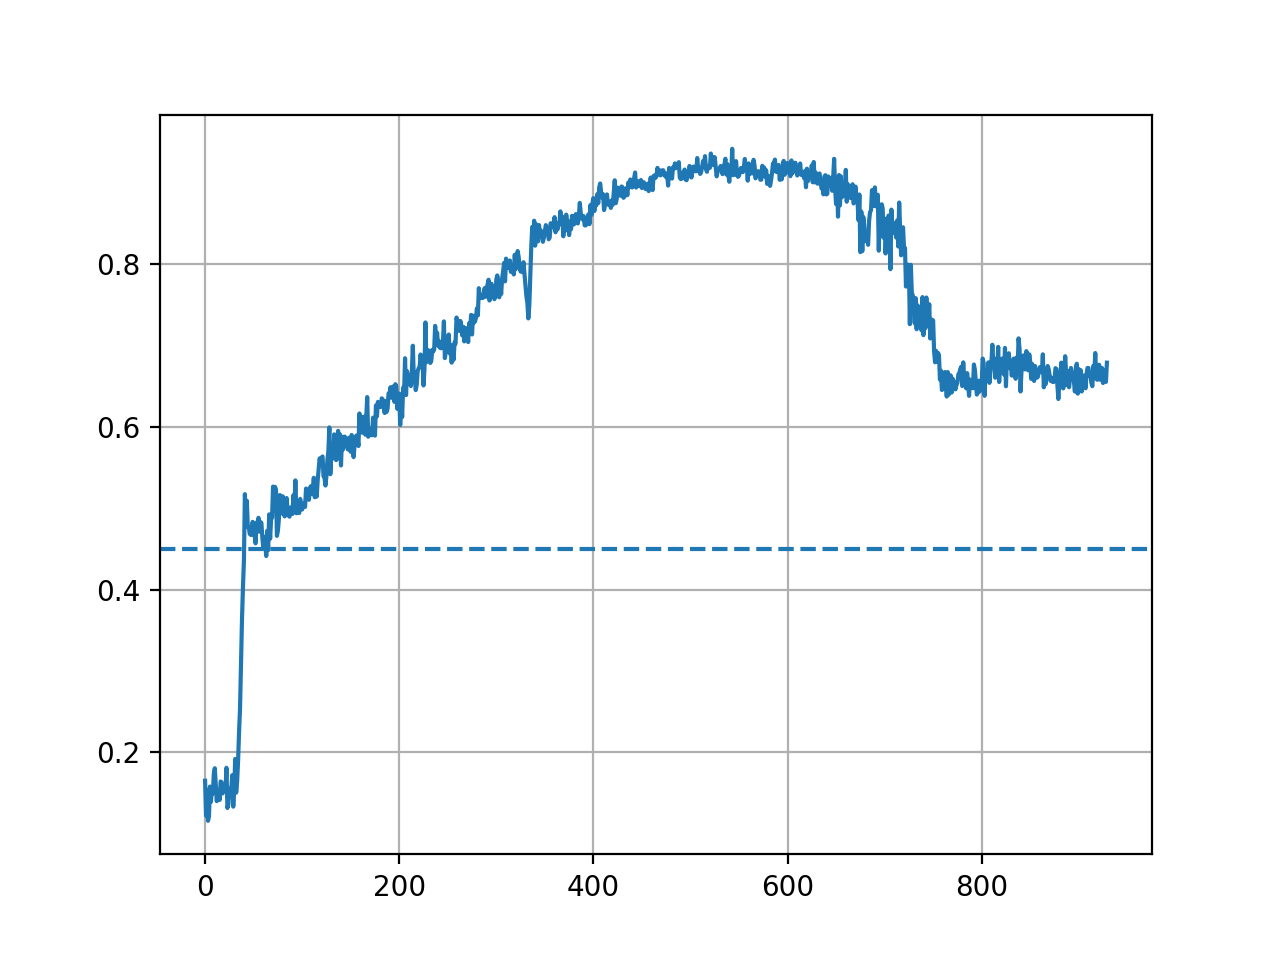

In [51]:
# Check the threshold for detecting the ball
fig=plt.figure()
plt.grid()
plt.plot(maxvals)
plt.axhline(INTENSITY_THRESHOLD,ls='--')
plt.show()

In [52]:
# Remove any outliers based on a maximum or minimum displacement.
MAX_DS_PX=5.0

# Fill outliers with a linear interpolation
p=np.arange(xy_peak.shape[0])
flt=~np.isnan(xy_peak[:,0])
for i in np.where(np.isnan(xy_peak[:,0]))[0]:
    xy_peak[i,0] = np.interp(i,p[flt],xy_peak[flt,0])
    xy_peak[i,1] = np.interp(i,p[flt],xy_peak[flt,1])

# Find displacements
dx = np.hstack((0,np.diff(xy_peak[:,0]) ))
dy = np.hstack((0,np.diff(xy_peak[:,1]) ))
ds = np.nan_to_num(np.sqrt(dx**2 + dy**2))

xy_peak[ds>MAX_DS_PX,:] = np.nan # mask maximum displacement
xy_peak[ds==0,:] = np.nan # mask zero displacement
xy_peak[np.isnan(ds),:] = np.nan # mask NaN displacement

# Fill outliers with linear interpolation again.
p=np.arange(xy_peak.shape[0])
flt=~np.isnan(xy_peak[:,0])
for i in np.where(np.isnan(xy_peak[:,0]))[0]:
    xy_peak[i,0] = np.interp(i,p[flt],xy_peak[flt,0])
    xy_peak[i,1] = np.interp(i,p[flt],xy_peak[flt,1])
    
xy_peak = np.round(xy_peak,0) # make integers

# Find displacement (correcting for out of plane angle!)
s= np.sqrt(xy_peak[:,0]**2 + (xy_peak[:,1]/np.cos(THETA))**2) 
s-=s[0]
ds = np.hstack((0,np.diff(s)))

<IPython.core.display.Javascript object>


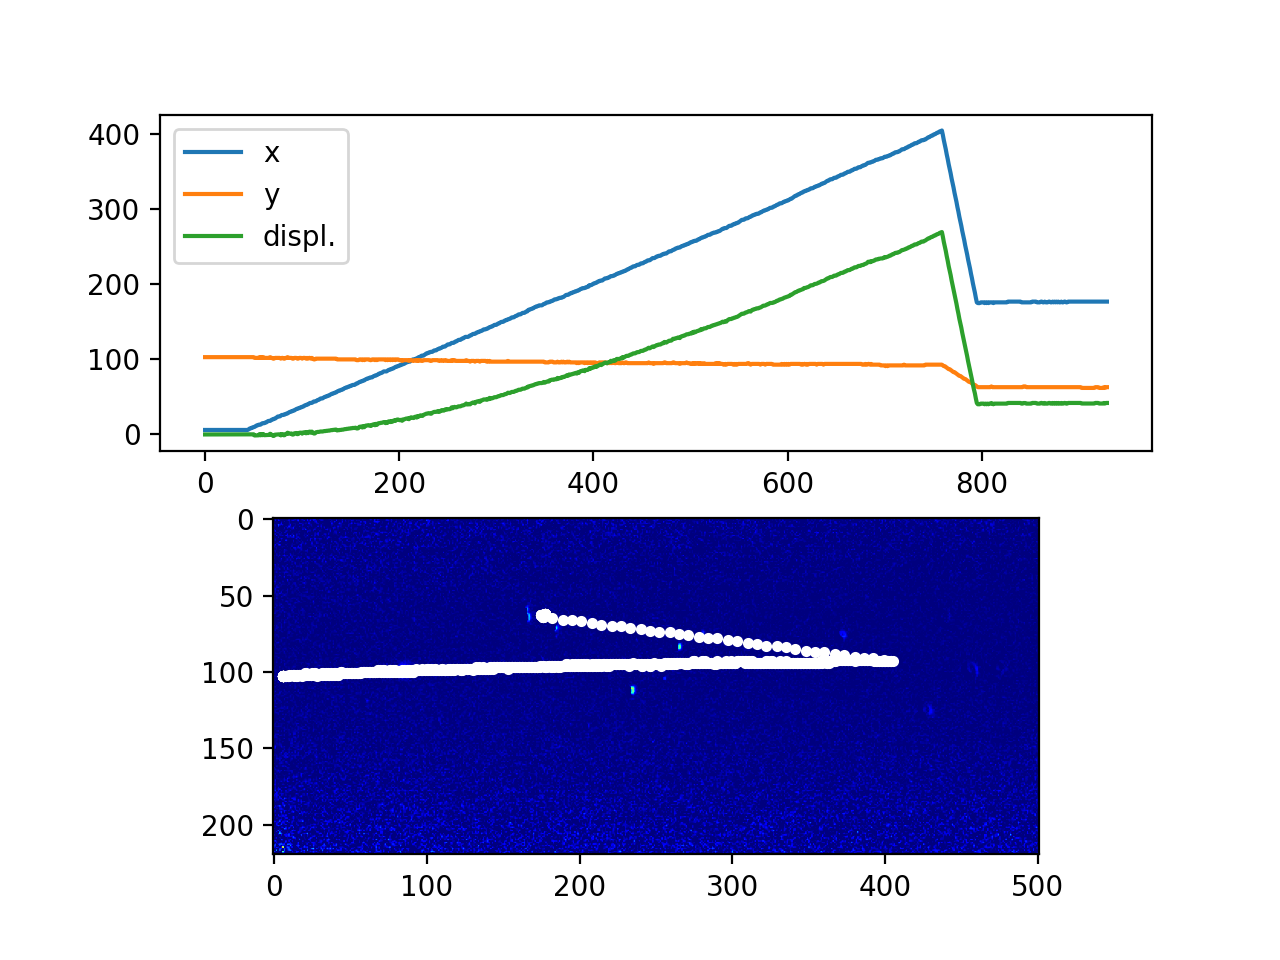

In [53]:
n=int(I.N/5)

fig=plt.figure()
ax=fig.add_subplot(211)
ax.plot(xy_peak)#,marker='o')
ax.plot(s)#,marker='o')
plt.legend(['x','y','displ.'])
ax=fig.add_subplot(212)
h=ax.imshow(Ib[n,...],cmap=plt.cm.jet,vmin=0,vmax=1)
ax.scatter(xy_peak[:,0],xy_peak[:,1],marker='.',lw=1,c='w',zorder=2)
#plt.colorbar(h)
plt.show()

# Use Cross-correlation to improve the displacement estimate
The local maxima is only approximate and will only be accurate to within 1 diameter of the ball, several pixels. Use cross-correlation instead to find the subpixel shift.

In [54]:
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-y)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

def crossCorrelate_interrogationWindowShifted(Ib,n,xy_peak,stride=1,xo=0,yo=0,WINDOW_SZ=32):
    """Cross-correlate and fit a 2D gaussian for subpixel accuracy.
        Use WINDOW_SZ window around the point xy_peak.
        Apply a frame-stride 'stride' and x,y offset xo,yo to reduce 
        peak-locking. Ib is the image array, n the first frame."""
    O = np.zeros((WINDOW_SZ,WINDOW_SZ))

    
    # extract window images
    try:
        
        # Check not going past last frame
        if n+stride >= Ib.shape[0]:
            return (np.nan,np.nan),O,O,O,(np.nan,np.nan,np.nan,np.nan,np.nan)
        
        # Make interrogation windows.
        a=int(xy_peak[n,1]-WINDOW_SZ/2)
        b=int(xy_peak[n,1]+WINDOW_SZ/2)
        c=int(xy_peak[n,0]-WINDOW_SZ/2)
        d=int(xy_peak[n,0]+WINDOW_SZ/2)
        xc=0;yc=0        # Check clipping.
        if(a<0):
            yc=-a
            b-=a
            a=0
        if(c<0):
            xc=-c
            d-=c
            c=0
        I1=Ib[n, a:b, c:d ]
        
        n2=n+stride # which frame to use for center (n or n+stride)
        a=int(xy_peak[n2,1]-WINDOW_SZ/2)+yo
        b=int(xy_peak[n2,1]+WINDOW_SZ/2)+yo
        c=int(xy_peak[n2,0]-WINDOW_SZ/2)+xo
        d=int(xy_peak[n2,0]+WINDOW_SZ/2)+xo
        if(a<0):
            yc-=a
            b-=a
            a=0
        if(c<0):
            xc-=c
            d-=c
            c=0
        I2=Ib[n+stride, a:b, c:d ]
        
        # compute CC
        F1=np.fft.fft2(np.nan_to_num(I1)-np.nanmean(I1))
        F2=np.fft.fft2(np.nan_to_num(I2)-np.nanmean(I2))
        Conv=F1*np.conj(F2)
        CC=np.fft.fftshift(np.fft.ifft2(Conv))

        # Fit 2D Gaussian to CC
        params = fitgaussian(np.abs(CC))
        
        # Only record displacements when CC peak sufficiently large.
        if params[0]<=0: dx_gauss=np.array((0,0))
        else: dx_gauss = params[1:1+2]-WINDOW_SZ/2.

        # Limit max displacement from frame to frame
        if(np.any(np.abs(dx_gauss)>WINDOW_SZ)): dx_gauss=np.array((0,0))
            
        # Absolute displacement - window center
        #dx_window = xy_peak[n,:]
        #dx_window -= np.array((yo+yc,xo+xc)) # account for window manual offset and clipping
        #dx_subpixel = dx_gauss +  dx_window
        
        # Velocity - window center shift correction
        dx_window = xy_peak[n,:] - xy_peak[n2,:]
        dx_window += np.array((yo+yc,xo+xc)) # account for window manual offset and clipping
        dx_subpixel = - (dx_gauss + dx_window)
        
        # Divide by stride n frames to get displacement or velocity per frame.
        dx_subpixel /= float(stride)
        
        #print(dx_window,dx_gauss,dx_subpixel)
        
    except:
        raise
        return (np.nan,np.nan),O,O,O,(np.nan,np.nan,np.nan,np.nan,np.nan)
    
    return dx_subpixel,I1,I2,CC,params

<IPython.core.display.Javascript object>


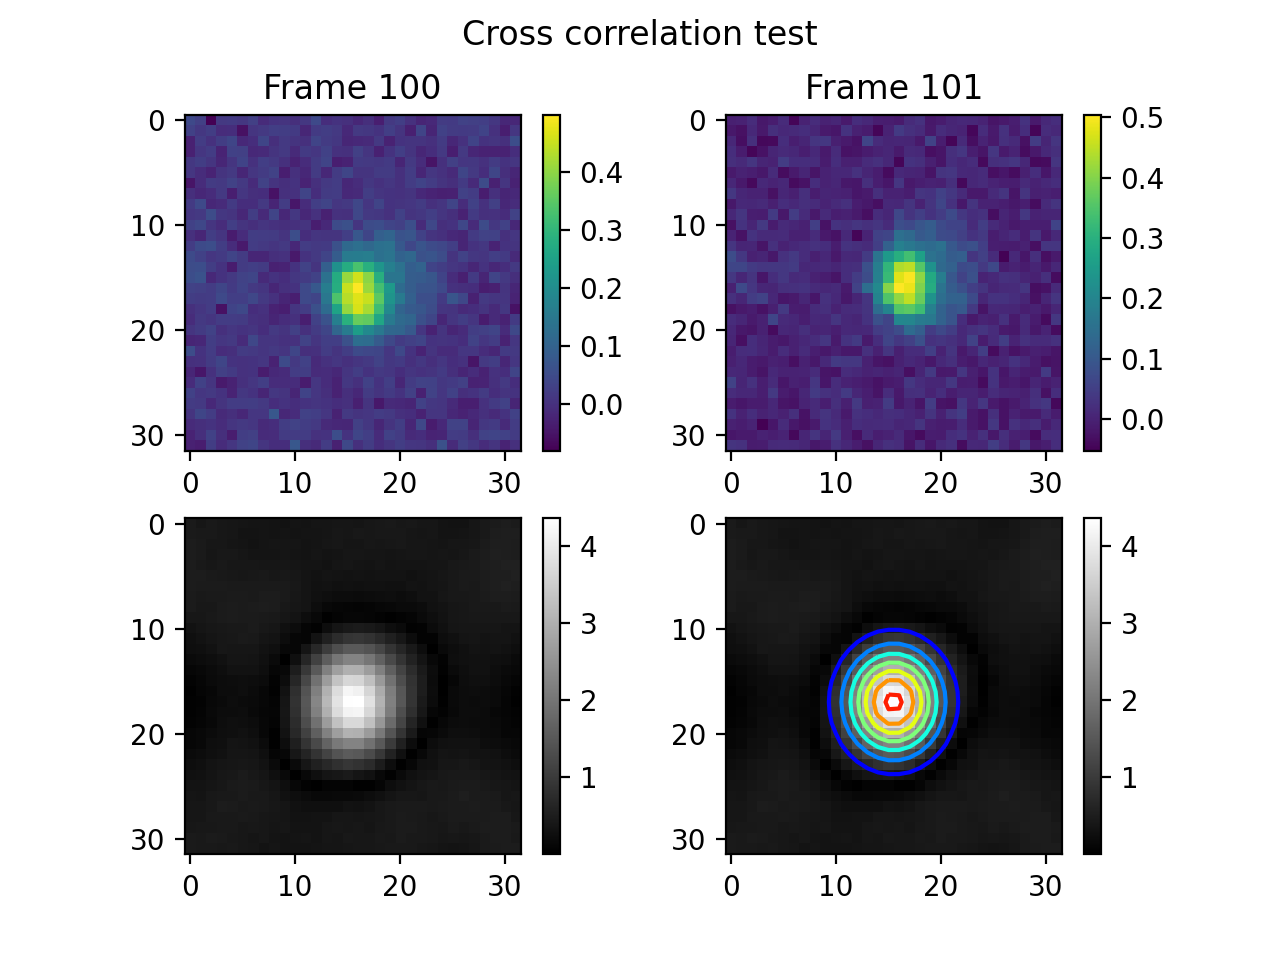

In [55]:
# Run a little test
n=100
dx_subpixel,I1,I2,CC,params=crossCorrelate_interrogationWindowShifted(Ib,n,xy_peak,stride=1)

# Plot the result
fig=plt.figure()
ax=fig.add_subplot(221)
h=ax.imshow(I1); plt.colorbar(h)
plt.title("Frame %i" % n )
ax=fig.add_subplot(222)
h=ax.imshow(I2); plt.colorbar(h)
plt.title("Frame %i" % (n+1) )
ax=fig.add_subplot(223)
h=ax.imshow(np.abs(CC),cmap=plt.cm.gray); plt.colorbar(h)
ax=fig.add_subplot(224)
h=ax.imshow(np.abs(CC),cmap=plt.cm.gray); plt.colorbar(h)
fit = gaussian(*params)
ax.contour(fit(*np.indices(CC.shape)),cmap=plt.cm.jet)
plt.suptitle("Cross correlation test")
plt.show()

## Run cross-correlation on all the frames
Then plot the velocity

In [56]:
cc_data = []
STRIDE_FRAMES=5

# Parallel
#cc_data = Parallel(n_jobs=-1,verbose=5)(delayed(crossCorrelate_interrogationWindowShifted)(Ib,n,xy_peak,stride=STRIDE_FRAMES) for n in range(I.N))

# Serial
for n in tqdm.tqdm(range(I.N)): cc_data.append(crossCorrelate_interrogationWindowShifted(Ib,n,xy_peak,stride=STRIDE_FRAMES))

  0%|                                                                                                                                                                                                               | 0/930 [00:00<?, ?it/s]/usr/local/lib/python3.9/site-packages/scipy/optimize/minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 930/930 [00:03<00:00, 236.72it/s]


<IPython.core.display.Javascript object>


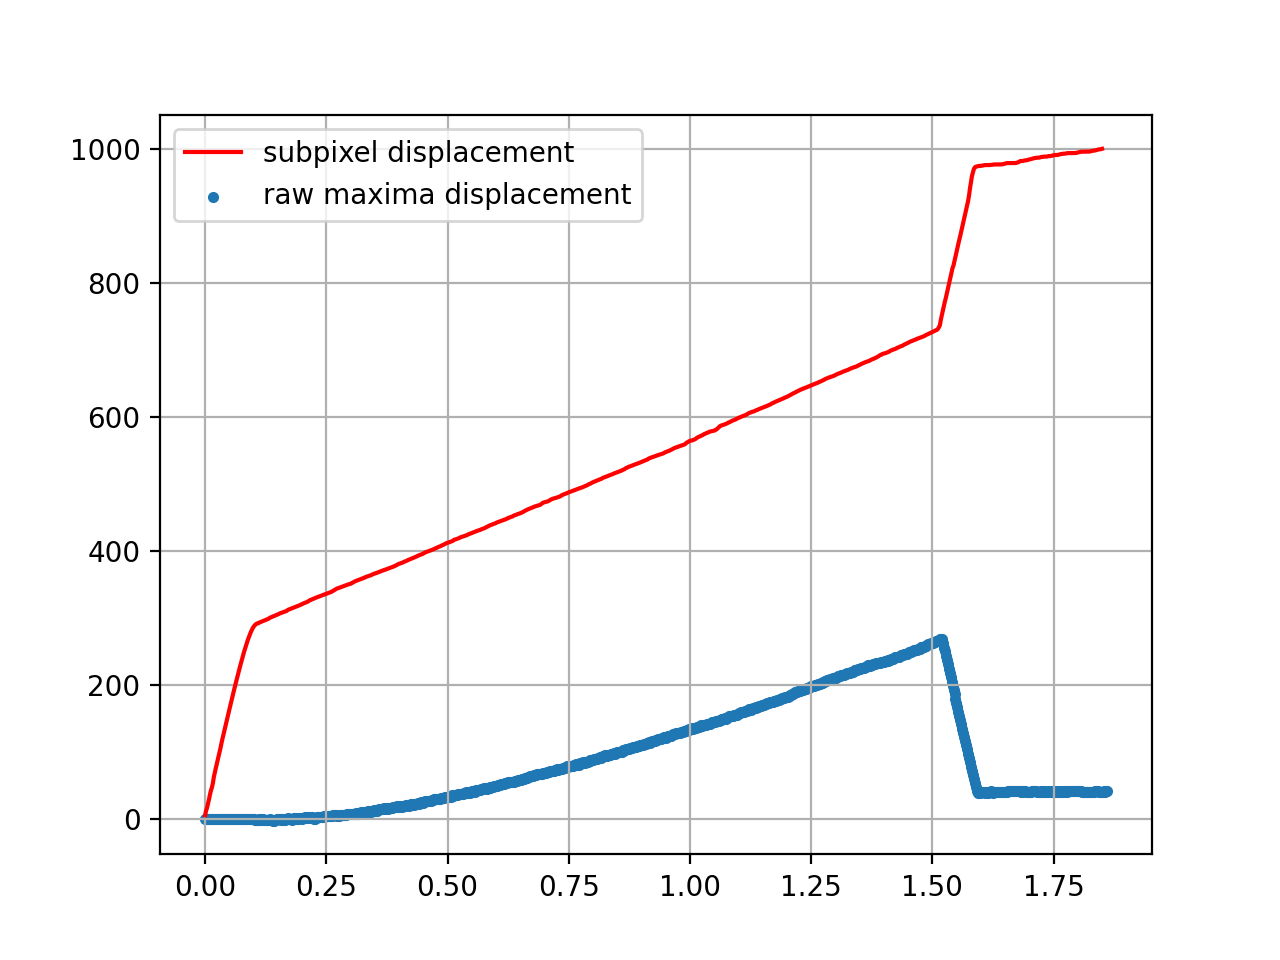

In [58]:
# Correcting for out of plane angle to convert to displacement parallel to surface.
xy_subpixel = np.array([ cc_data[i][0] for i in range(len(cc_data)) ])
v_subpixel = np.sqrt( (xy_subpixel[:,1]/np.cos(THETA))**2 + xy_subpixel[:,0]**2 )
t = np.linspace( 0, I.N/float(FRAME_RATE), I.N )

fig=plt.figure()
ax=fig.add_subplot(111)
ax.grid()
ax.scatter(t,s,marker='.',label='raw maxima displacement')
ax.plot(t,np.cumsum(v_subpixel),c='r',label='subpixel displacement')
plt.legend()
plt.show()

# Fit terminal velocity

In [59]:
def centralDiff1(y,h=1,step=1,order=2):
    # first and second derivative to arb. order, central difference y' with step size h
    if   order==2: coeff=(-0.5,0,0.5)
    elif order==4: coeff=(1/12.,-2/3.,0,2/3.,-1/12.)
    elif order==6: coeff=(-1/60.,3/20.,-3/4.,0,3/4.,-3/20.,1/60.)
    elif order==8: coeff=(1/280.,-4/105.,1/5.,-4/5.,0,4/5.,-1/5.,4/105.,-1/280.)
    else: raise ValueError("Bad order for central difference")
    m=int((len(coeff)-1)/2)
    yprime = np.zeros_like(y)
    for i in range(m*step,len(y)-m*step,step):
        yprime[i]=np.sum( [ coeff[j]*y[i+j-m] for j in range(len(coeff)) ] )/float(h)
    
    if   order==2: coeff2=(1,-2,1)
    elif order==4: coeff2=(-1/12.,4/3.,-5/2.,4/3.,-1/12.)
    elif order==6: coeff2=(1/90.,-3/20.,3/2.,-49/18.,3/2.,-3/20.,1/90.)
    elif order==8: coeff2=(-1/560.,8/315.,-1/5.,8/5.,-205/72.,8/5.,-1/5.,8/315.,-1/560.)
    else: raise ValueError("Bad order for central difference")
    m=int((len(coeff2)-1)/2)
    yprime2 = np.zeros_like(y)
    for i in range(m*step,len(y)-m*step,step):
        yprime2[i]=np.sum( [ coeff2[j]*y[i+j-m] for j in range(len(coeff2)) ] )/float((h)**2)

    return yprime, yprime2

Velocity = 0.582417 pixels/frame
Acceleration = 0.052007 pixels/frame


<IPython.core.display.Javascript object>


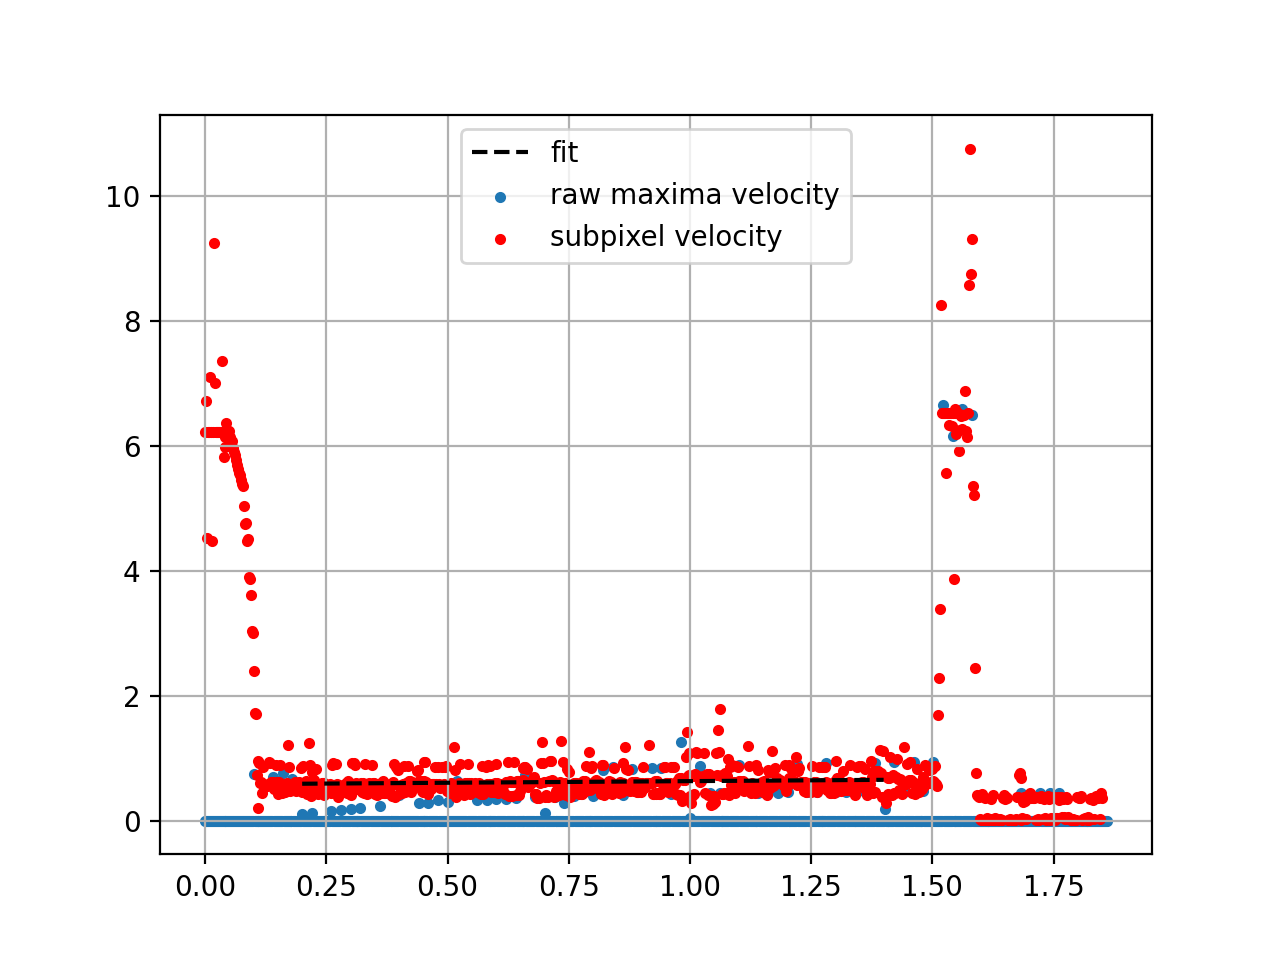

In [61]:
# Fit terminal velocity
f = lambda a,b,x: a*x+b
valid_time=(0.2,1.4)#(1,5)
flt=(t>valid_time[0]) & (t<valid_time[1]) & ~np.isnan(v_subpixel)
popt, pcov = optimize.curve_fit(f,t[flt],v_subpixel[flt])
print("Velocity = %f pixels/frame" % popt[0])
print("Acceleration = %f pixels/frame" % popt[1])

v,a=centralDiff1(s,step=10,order=2) # estimate velocity from rough displacement data

fig=plt.figure()
ax=fig.add_subplot(111)
ax.grid()
ax.scatter(t,np.abs(v),marker='.',label='raw maxima velocity')
ax.scatter(t,v_subpixel,c='r',marker='.',label='subpixel velocity')
ax.plot(t[flt],f(t[flt],*popt),c='k',ls='--',label='fit')
plt.legend()
plt.show()